# Task

Predict the rating a user will give a product.

# Importing Libraries & Data

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import math 

In [20]:
# Importing Data
products = pd.read_csv("data/product_info.csv")
reviews = pd.read_csv("data/reviews_0-250.csv",index_col=0) # only using first 100_000 rows of reviews

/var/folders/_n/2lzdwcvx2n9087rmk11qlfdw0000gn/T/ipykernel_8296/2225516502.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv("data/reviews_0-250.csv",index_col=0) # only using first 100_000 rows of reviews


In [21]:
print(products.shape)
print(reviews.shape)

(8494, 27)
(602130, 18)


In [22]:
reviews.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'],
      dtype='object')

# Exploratory Data Analysis

In [23]:
# Querying for necessary columns
products = products[['product_id','brand_id','loves_count','rating','reviews','price_usd','primary_category']]
reviews = reviews[['author_id','product_id','rating','is_recommended','helpfulness','submission_time','review_text','review_title']]

## Null Values

In [24]:
# Percentages of null data 

In [25]:
reviews.isnull().sum() / reviews.shape[0]

author_id          0.000000
product_id         0.000000
rating             0.000000
is_recommended     0.195117
helpfulness        0.551097
submission_time    0.000000
review_text        0.001659
review_title       0.277367
dtype: float64

In [26]:
products.isnull().sum() / products.shape[0]

product_id          0.000000
brand_id            0.000000
loves_count         0.000000
rating              0.032729
reviews             0.032729
price_usd           0.000000
primary_category    0.000000
dtype: float64

## Univariate Analysis

Text(0.5, 1.0, 'Distribution of Product Ratings')

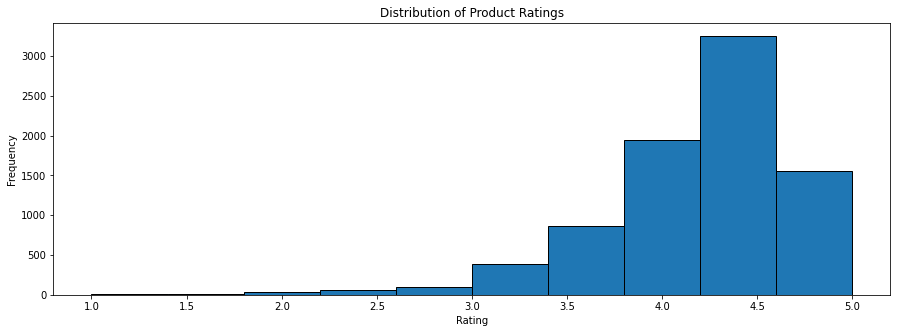

In [32]:
# Set the size of the figure
plt.figure(figsize=(15, 5))

# Plotting the histogram
plt.hist(products['rating'], edgecolor='black')

# Adding labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Product Ratings')

Ratings are skewed to being more positive.

Text(0.5, 1.0, 'Distibution of Product Counts')

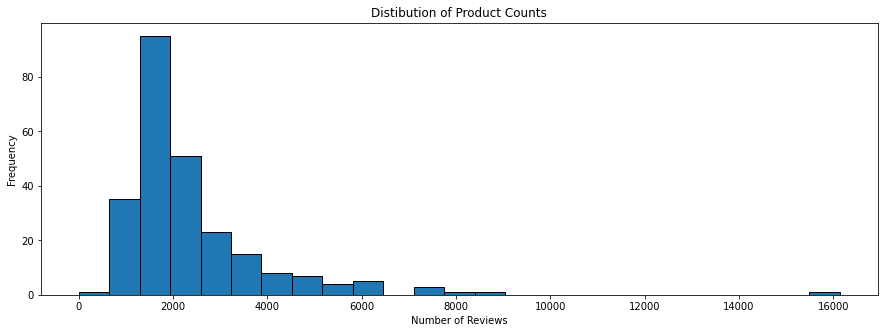

In [35]:
product_counts = reviews.groupby("product_id")["author_id"].count().fillna(0)

# Set the size of the figure
plt.figure(figsize=(15, 5))

# Plotting the histogram
plt.hist(product_counts, edgecolor='black', bins=25)

# Adding labels and title
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Distibution of Product Counts')

Reviews for each product seem to represent a right-skewed distribution. However there are some outliers that have 8,000+ and even 16,000+ reviews. 

Text(0.5, 1.0, 'Histogram of Product Counts')

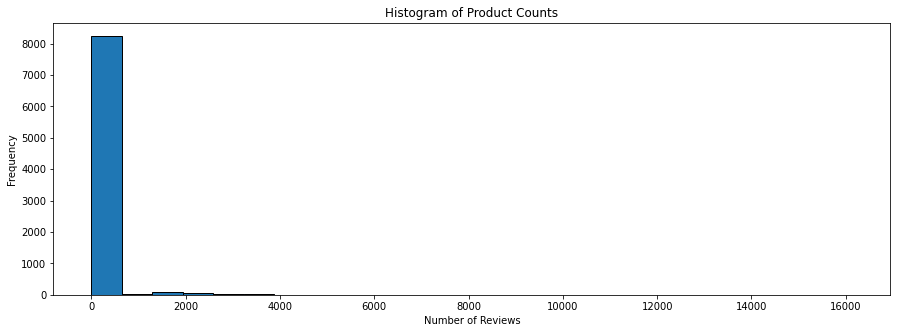

In [36]:
product_counts = reviews.groupby("product_id")["author_id"].count().to_dict()
products["review_counts"] = products["product_id"].map(product_counts).fillna(0)

# Set the size of the figure
plt.figure(figsize=(15, 5))

# Plotting the histogram
plt.hist(products["review_counts"], edgecolor='black', bins=25)

# Adding labels and title
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Histogram of Product Counts')

Vast majority of products in the dataset do not have reviews. 

## Bivariate Analysis

Text(0.5, 1.0, 'Rating vs Number of Reviews')

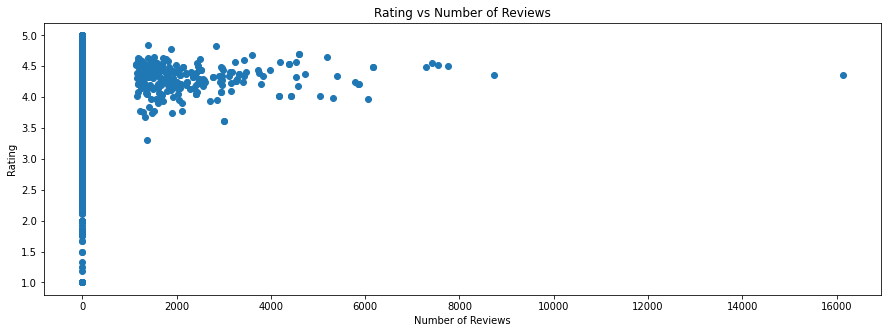

In [39]:
# Set size
plt.figure(figsize=(15,5))

plt.scatter(data=products, x="review_counts", y="rating")

# Adding Labels
plt.xlabel("Number of Reviews")
plt.ylabel("Rating")
plt.title("Rating vs Number of Reviews")

No correlation for number of reviews and the rating of a product.

In [59]:
products["has_reviews"] = 0 
products.loc[products["review_counts"] > 0, "has_reviews"] = 1

In [80]:
no_reviews.rating.mean()

4.191042430328897

In [81]:
has_reviews.rating.mean()

4.3050956000000005

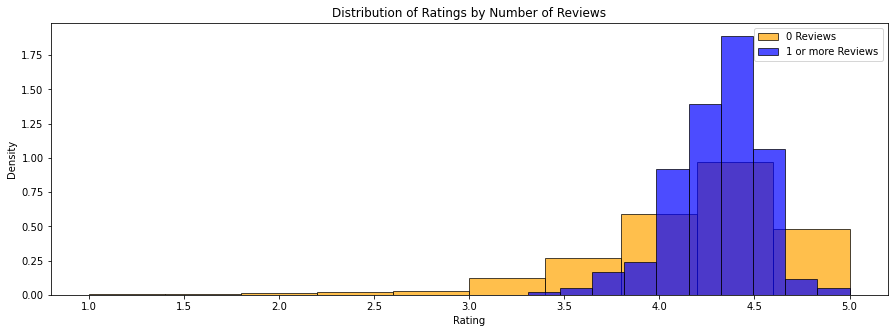

In [87]:
# Size 
plt.figure(figsize=(15,5))
# Seperating data by "has_reviews"
mean_no_reviews = products[products["has_reviews"] == 0]
mean_has_reviews = products[products["has_reviews"] == 1]

# Create side-by-side histograms
plt.hist(no_reviews['rating'], color='orange', edgecolor='black', alpha=0.7, label='0 Reviews', density=True)
plt.hist(has_reviews['rating'], color='blue', edgecolor='black', alpha=0.7, label='1 or more Reviews', density=True)

# Set labels and title
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Distribution of Ratings by Number of Reviews')
plt.legend()

Products with 1 or more reviews has a "skinnier" distribution around 4.3 while the products with 0 reviews have a more wide distribution coveringa larger range of values. Which means our model will probbaly tend to rate higher values and may not be able to predict lower ratings because those products don't appear in the reviews table.

# Baseline Models

## Creating Training and Testing Sets

In [91]:
# Create training and test set for reviews 
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(reviews, test_size=0.2, random_state=42)

In [92]:
# Splitting data and maintaining distribution of ratings in training and test set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in split.split(reviews, reviews["rating"]):
        strat_train_set = reviews.loc[train_index]
        strat_test_set = reviews.loc[test_index]

In [93]:
reviews.rating.value_counts() / len(reviews)

rating
5    0.646040
4    0.177629
3    0.073104
1    0.054644
2    0.048583
Name: count, dtype: float64

In [94]:
strat_train_set.rating.value_counts() / len(strat_train_set)

rating
5    0.646040
4    0.177630
3    0.073103
1    0.054646
2    0.048582
Name: count, dtype: float64

## Predict Average Rating

A simple model we can implement is to predict that a user will give a product its already average rating.

In [114]:
itemAvg = products.set_index('product_id')['rating'].to_dict()
globalAvg = products['rating'].mean()
print(globalAvg)

4.194512889483933


In [96]:
def avgRating(product_id):
    if product_id not in itemAvg: # return globalAvg if product has not been seen before
        return [globalAvg]
    return [itemAvg[product_id]]

In [99]:
# Predicting ratings
y = np.array(strat_test_set.rating)
y_pred = strat_test_set.product_id.apply(avgRating).to_list()

In [100]:
# Model Evaluation
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f'MSE:{mse}')
print(f'RMSE:{rmse}') 

MSE:1.260001177844153
RMSE:1.122497740685545


This model's predictions are off by about 1.12. Since rating go from a scale from 1 - 5 this model performs pretty bad being off by 1.12 is pretty bad.

## User & Item Deviations Model

Another model we can exlore is to determine the deviations each user has in their personal ratings and the deviations each item has compared to the global averages. 

In [101]:
# Functions for the model 

# Create feature vector
def features(datum, alpha, betaU, betaI):
    user = datum.author_id
    item = datum.product_id
    
    # logic for users or items not seen in the training set
    if user in betaU:
        bu = betaU[user]
    else:
        bu = 0
        
    if item in betaI:
        bi = betaI[item]
    else:
        bi = 0
        
    return [alpha, bu, bi]

def predict_rating(datum):
    a = datum[0]
    bu = datum[1]
    bi = datum[2]
    return a + bu + bi

In [102]:
ratingsPerUser = strat_train_set.groupby('author_id')['rating'].count().to_dict()
ratingsPerItem = strat_train_set.groupby('product_id')['rating'].count().to_dict()

userAvg = strat_train_set.groupby('author_id')['rating'].mean().to_dict()
products = products.dropna(subset=['rating'])
itemAvg = products.set_index('product_id')['rating'].to_dict()
# ratingMean = sum(itemAvg.values()) / len(itemAvg)
# ratingMean # based on avg product reviews

In [104]:
# usersPerItem = defaultdict(set)
# itemsPerUser = defaultdict(set)
# reviewsPerUser = defaultdict(list)

# for index, review in strat_train_set.iterrows():
#     user_id = review['author_id']
#     item_id = review['product_id']
#     rating = float(review['rating'])

#     usersPerItem[item_id].add(user_id)
#     itemsPerUser[user_id].add(item_id)

#     reviewsPerUser[user_id].append(review)
    
# userReviewAverages = {}
# itemReviewAverages = {}

# for u in itemsPerUser:
#     rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
#     userReviewAverages[u] = sum(rs) / len(rs)
    
# for i in usersPerItem:
#     rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
#     itemReviewAverages[i] = sum(rs) / len(rs)
    
# ratingMean = sum(itemReviewAverages.values())/len(itemReviewAverages)
# ratingMean # based on reviews

In [105]:
MSEs = defaultdict(list)

In [123]:
# Initializing values 

alpha = globalAvg
betaU = {}
betaI = {}

for u in userAvg:
    betaU[u] = userAvg[u] - alpha
for i in itemAvg:
    betaI[i] = itemAvg[i] - alpha

# Opitmization (Gradient Descent) 

lam = 0 # can change to increase/descrease error  

prev_mse = 0
iteration = 1

# Training sets
y = np.array(strat_train_set.rating)

for i in range(1):
    alphas = []
    betaUs = defaultdict(list)
    betaIs = defaultdict(list)
    
    for index, row in tqdm(strat_train_set.iterrows()):
        user = row.author_id
        item = row.product_id
        rating = row.rating
        bu = betaU[user]
        bi = betaI[item]

        alphas.append(rating - (bu + bi))
        betaUs[user].append(rating - (alpha + bi))
        betaIs[item].append(rating - (alpha + bu))
    
    alpha = sum(alphas) / len(strat_train_set)
    
    for u in betaUs:
        betaU[u] = sum(betaUs[u]) / (lam + ratingsPerUser[u])

    for i in betaIs:
        betaI[i] = sum(betaIs[i]) / (lam + ratingsPerItem[i])

    # Caclculate MSE 
    X = [features(row, alpha, betaU, betaI) for index,row in strat_train_set.iterrows()]
    y_pred = [predict_rating(x) for x in X]
    trainMse = mean_squared_error(y, y_pred)
    
    print(f"Iteration {iteration}, MSE: {trainMse}, MSE Difference: {abs(prev_mse-trainMse)}")
    if abs(trainMse - prev_mse) < 0.1 or (prev_mse < trainMse and prev_mse != 0): break
    
#    MSEs[lam].append((trainMse, iteration))
    iteration += 1
    prev_mse = trainMse

481704it [00:30, 15927.98it/s]


Iteration 1, MSE: 0.2869475500189116, MSE Difference: 0.2869475500189116


In [124]:
# Keeping track of beset lambdas 
MSEs = {0:(1,0.2869475500189116), 0.5:(1,0.37123573326746806),0.7:(1,0.417800212704393),
        1.1:(1,0.5051117828232283), 1.2:(1,0.5250825093376316), 1.3:(1,0.5442690897035047),
        1.5:(1,0.5803521882037794), 1.7:(1,0.6135531708458034)}

In [125]:
# Model Evaluation

In [126]:
X_test = [features(row, alpha, betaU, betaI) for index,row in strat_test_set.iterrows()]
y_pred = [predict_rating(x) for x in X_test]
y = np.array(strat_test_set.rating)

testMse = mean_squared_error(y, y_pred)
testRmse = np.sqrt(testMse)
print(f'Test MSE: {testMse}')
print(f'Test RMSE: {testRmse}')

Test MSE: 1.2062849300869145
Test RMSE: 1.0983100336821632


## Jaccard Similarity Model

In [164]:
def MSE(predictions,y):
    differences = [(x-y[2])**2 for x,y in zip(predictions,y)]
    return sum(differences) / len(differences)

In [131]:
# Data Structures for Model
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
reviewsPerUser = defaultdict(list)

for index, review in strat_train_set.iterrows():
    user_id = review['author_id']
    item_id = review['product_id']
    rating = float(review['rating'])

    usersPerItem[item_id].add(user_id)
    itemsPerUser[user_id].add(item_id)

    reviewsPerUser[user_id].append(review)
    
y = []
for index, row in strat_test_set.iterrows():
    y.append((row['author_id'], row['product_id'], row['rating'] ))

In [132]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [133]:
def predictRating1(user,item):
    if item not in itemAvg:
        return ratingMean
    ratings = [] 
    sims = []
    for d in reviewsPerUser[user]:
        j = d['product_id']
        if j == item: continue  
        ratings.append(d['rating'] - itemAvg[j])
        sims.append(Jaccard(usersPerItem[item],usersPerItem[j]))
    if (sum(sims) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,sims )]
        return itemAvg[item] + (sum(weightedRatings) / sum(sims))
    else:
        return itemAvg[item] 

In [134]:
# using jaccard similarity 
predictions = []
for (user_id,item_id,_)  in y:
    prediction = predictRating1(user_id, item_id)
    if (prediction > 5):
        prediction = 5
    predictions.append(prediction) 

In [136]:
mse = MSE(predictions, y)
rmse = np.sqrt(mse)
print(f'Jaccard Sim MSE: {mse}')
print(f'Jaccard Sim RMSE: {rmse}')

Jaccard Sim MSE: 1.058900776185314
Jaccard Sim RMSE: 1.0290290453555302


## Cosine Similarity Model

In [141]:
# Data Structures 
ratingDict = {}
for index, review in strat_train_set.iterrows():
    user_id = review['author_id']
    item_id = review['product_id']
    rating = float(review['rating'])

    ratingDict[(user_id, item_id)] = rating

In [142]:
def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        #print(ratingDict[(u,i1)])
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [146]:
def predictRating2(user,item):
    if item not in itemAvg:
        return ratingMean
    ratings = [] 
    sims = []
    for d in reviewsPerUser[user]:
        j = d['product_id']
        if j == item: continue  
        ratings.append(d['rating'] - itemAvg[j])
        sims.append(Cosine(item,j))
    if (sum(sims) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,sims )]
        return itemAvg[item] + (sum(weightedRatings) / sum(sims))
    else:
        return itemAvg[item] 

In [148]:
# using cosine similarity 
predictions = []
for (user_id,item_id,_)  in tqdm(y):
    prediction = predictRating2(user_id, item_id)
    if (prediction > 5):
        prediction = 5
    predictions.append(prediction) 

100%|██████████████████████████████████| 120426/120426 [09:01<00:00, 222.40it/s]


In [149]:
mse = MSE(predictions, y)
rmse = np.sqrt(mse)
print(f'Cosine Sim MSE: {mse}')
print(f'Cosine Sim RMSE: {rmse}')

Cosine Sim MSE: 1.0598484012773837
Cosine Sim RMSE: 1.0294893886181555


## Pearsons Similarity Model

In [150]:
def Pearsons(i1,i2):
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    
    ratings_s1 = [ratingDict[(u, i1)] for u in inter]
    ratings_s2 = [ratingDict[(u, i2)] for u in inter]
    
    smaller_len = len(inter)
    
    if smaller_len == 0:
        return 0

    s1_sum = sum(ratings_s1)
    s2_sum = sum(ratings_s2)

    s1_sqsum = sum([rating ** 2 for rating in ratings_s1])
    s2_sqsum = sum([rating ** 2 for rating in ratings_s2])

    prod = sum([ratings_s1[i] * ratings_s2[i] for i in range(smaller_len)])

    numer = prod - ((s1_sum * s2_sum) / smaller_len)
    denom = ((s1_sqsum - (s1_sum ** 2) / smaller_len) * (s2_sqsum - (s2_sum ** 2) / smaller_len)) ** 0.5
        
    if denom == 0:
        return 0
    
    if (isinstance(numer / denom, complex)):
        return 0
    
    
    return numer / denom 

In [151]:
def predictRating3(user,item):
    # if item not seen before, returning the global average
    if item not in itemAvg:
        return ratingMean
    ratings = [] # ratings to average 
    sims = [] # similarity scores
    for d in reviewsPerUser[user]:
        j = d['product_id']
        if j == item: continue # skipping query item  
        ratings.append(d['rating'] - itemAvg[j])
        sims.append(Pearsons(item,j))
       

    if (sum(sims) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,sims )]
        return itemAvg[item] + (sum(weightedRatings) / sum(sims))
    else:
        # returning the item’s average rating if no similar items exist
        return itemAvg[item] 

In [158]:
predictions = []
for (user_id,item_id,_)  in tqdm(y):
    prediction = predictRating3(user_id, item_id)
    if (prediction > 5):
        prediction = 5
    predictions.append(prediction) 

100%|█████████████████████████████████| 120426/120426 [01:49<00:00, 1100.24it/s]


In [163]:
mse = MSE(predictions, y) 
rmse = np.sqrt(mse)
print(f'Pearsons Correlation Coef MSE: {mse}')
print(f'Pearsons Correlation Coef RMSE: {rmse}')

Pearsons Correlation Coef MSE: 4294.864315267552
Pearsons Correlation Coef RMSE: 65.5352143146534


# Matrix Factorization Model (SVD)

In [153]:
# Importing Packages
from surprise import SVD , Reader , Dataset, accuracy, NormalPredictor
from surprise.model_selection import train_test_split, KFold, cross_validate

In [154]:
# Creating Model
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(reviews[['author_id', 'product_id', 'rating']], reader)
dataTrain, dataTest = train_test_split(data, test_size=.25)

model = SVD()
model.fit(dataTrain)
predictions = model.test(dataTest)

In [155]:
# Model Evaluation
sse = 0
for p in predictions:
    sse += (p.r_ui - p.est)**2
MSE = sse / len(predictions)
RMSE = np.sqrt(MSE)
print(f'SVD MSE: {MSE}')
print(f'SVD RMSE: {RMSE}')

SVD MSE: 1.0383113929817052
SVD RMSE: 1.0189756586796885


## Model Optimization (Cross Validation)

In [156]:
cross_validate(NormalPredictor(), data, cv=2)

{'test_rmse': array([1.45739262, 1.45477954]),
 'test_mae': array([1.06912579, 1.06803085]),
 'fit_time': (0.3128509521484375, 0.3758571147918701),
 'test_time': (1.0722291469573975, 1.045090913772583)}

## Model Optimization (K-Fold Validation)

In [157]:

kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.0113
RMSE: 1.0152
RMSE: 1.0174
RMSE: 1.0120
RMSE: 1.0081
